In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "images1"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lrg = 0.005
lrd = 0.0009

# Beta1 hyperparam for Adam optimizers
beta1 = 0.8

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

0it [00:00, ?it/s]

100%|█████████▉| 169861120/170498071 [00:14<00:00, 14964969.06it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


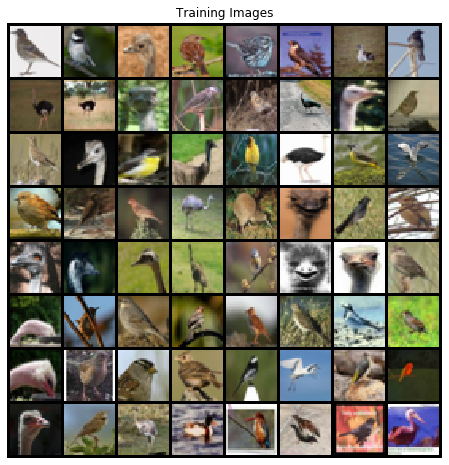

In [ ]:
def get_indices(dataset):
    indices =  []
    for i in range(len(dataset.targets)):  #use train_labels if error with tragets 
        if dataset.targets[i] == 2:
            indices.append(i)
    return indices

trainData = dset.CIFAR10('./data/', download=True, train=True,
                                          transform=transforms.Compose([
                                                    transforms.Resize(32),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                  ]))

idx = get_indices(trainData)

dataloader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx), num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(nc),
#             nn.Tanh()
#             # state size. (ngf) x 32 x 32
#         )

#     def forward(self, input):
#         return self.main(input)

#neural network for generative network
prob = 0.2
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(   nz , ngf*8 , 4 , 1 , 0 , bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.Dropout2d(p=prob),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8 , ngf*4 , 4 , 2 , 1 , bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.Dropout2d(p=prob),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4 , ngf*2 , 4 , 2 , 1 , bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.Dropout2d(p=prob),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2 , ngf , 4 , 2 , 1 , bias=False),
            nn.BatchNorm2d(ngf),
            nn.Dropout2d(p=prob),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            # nn.BatchNorm2d(nc),
            # nn.Dropout2d(p=prob),
            nn.Tanh()
        )
          
    def forward(self, input):
      output = self.model(input)
      return output

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout2d(p=0.2, inplace=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05,

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 32 x 32
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#             # state size. (1) x 4 x 4
#         )

#     def forward(self, input):
#         return self.main(input)

#neural network for discriminative model
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d( nc, ndf    , 3, 2, 2, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            # nn.Conv2d(ndf * 4, ndf * 4, 3, 2, 2, bias=False),
            # nn.BatchNorm2d(ndf * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),        

            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Dropout2d(p=0.4),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.model(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(2, 2), stride=(

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_noise = torch.FloatTensor(64,nz,1,1).uniform_(-1,1).to(device)

# Establish convention for real and fake labels during training
real_label = 0
fake_label = 1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrd, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrg, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = torch.FloatTensor(b_size,nz,1,1).uniform_(-1,1).to(device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/50][0/79]	Loss_D: 1.6169	Loss_G: 8.6494	D(x): 0.4431	D(G(z)): 0.4288 / 0.7890
[0/50][50/79]	Loss_D: 0.5676	Loss_G: 5.3809	D(x): 0.2253	D(G(z)): 0.8027 / 0.8114
[1/50][0/79]	Loss_D: 0.7145	Loss_G: 4.1394	D(x): 0.2166	D(G(z)): 0.7497 / 0.7762
[1/50][50/79]	Loss_D: 0.6930	Loss_G: 2.8786	D(x): 0.2773	D(G(z)): 0.7687 / 0.8022
[2/50][0/79]	Loss_D: 2.5431	Loss_G: 1.8659	D(x): 0.1720	D(G(z)): 0.2547 / 0.6561
[2/50][50/79]	Loss_D: 0.6793	Loss_G: 4.0201	D(x): 0.1579	D(G(z)): 0.6616 / 0.7632
[3/50][0/79]	Loss_D: 0.8380	Loss_G: 4.7243	D(x): 0.2873	D(G(z)): 0.6990 / 0.8343
[3/50][50/79]	Loss_D: 0.6693	Loss_G: 2.6796	D(x): 0.2043	D(G(z)): 0.7114 / 0.7506
[4/50][0/79]	Loss_D: 0.7961	Loss_G: 5.0720	D(x): 0.2750	D(G(z)): 0.7504 / 0.8204
[4/50][50/79]	Loss_D: 0.9823	Loss_G: 1.6619	D(x): 0.2745	D(G(z)): 0.5909 / 0.6930
[5/50][0/79]	Loss_D: 1.2232	Loss_G: 3.8812	D(x): 0.2289	D(G(z)): 0.4921 / 0.7815
[5/50][50/79]	Loss_D: 1.1537	Loss_G: 1.9881	D(x): 0.4585	D(G(z)): 0.7444 / 0.7

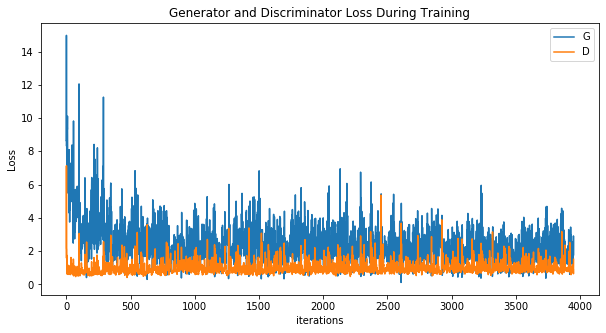

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

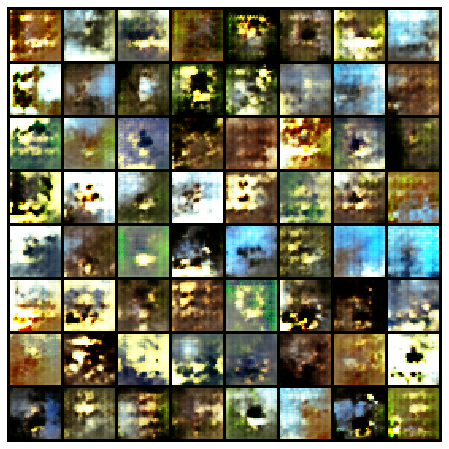

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

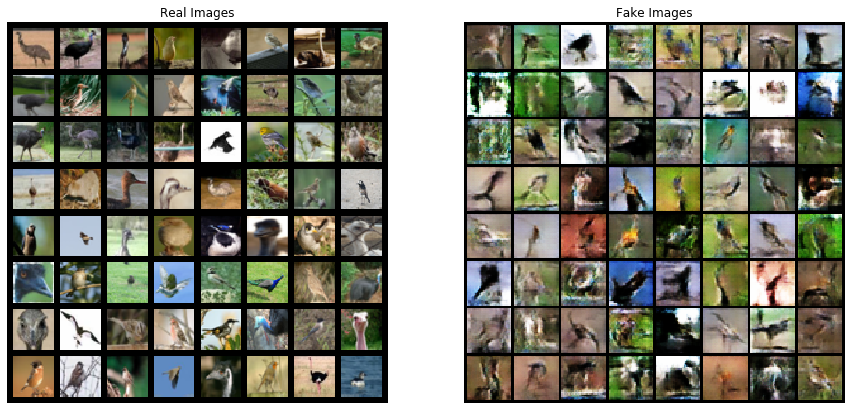

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
